This notebook contains code to plot the data/MC agreement of the DeepTau VSjet distribution as well as the y$_{adv}$ output

In [1]:
# Imports
from tensorflow.keras.models import load_model
import json
import os
import yaml
import gc
import sys
from glob import glob
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import uproot as up
import ROOT as R
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
sys.path.insert(0, "..")

Welcome to JupyROOT 6.26/02


In [2]:
yellow = (255/255,205/255,103/255)
red = (213/255, 88/255, 84/255)
purple = (152/255, 152/255, 201/255)
pink = (241/255, 204/255, 225/255)
blue = (47/255, 153/255, 205/255)
brown = (193/255, 131/255, 119/255)
green = (116/255, 204/255, 106/255)
light_yellow = (247/255, 243/255, 154/255)
orange = (206/255, 104/255, 50/255)

In [3]:
# Find indices of different types from original ROOT file
file = up.open("/home/russell/MuTau_dataset/Evaluate/adv_dataset_test.root")
types = file["taus"]["dataset_id"].array()
i_data = np.where(types==0)[0]
i_DYT = np.where(types==1)[0]
i_TTT = np.where(types==2)[0]
i_DYM = np.where(types==3)[0]
i_TTJ = np.where(types==4)[0]
i_WJ = np.where(types==5)[0]
i_QCD = np.where(types==6)[0]
i_MCtot = np.where(types!=0)[0]

# DeepTau VSjet Distribution - Adversarial Model

In [4]:
# Plotting function
w = 0.0025
low = 0.9
bin_list = np.arange(low, 1+w, w)

lower_lim = 0.9
bin_centre = bin_list[:-1]+ np.diff(bin_list)/2
                



def dt_steps(dt_binned, key):
    return np.append(dt_binned[f"{key}"][0], dt_binned[f"{key}"])

def plot(scores, weights, runid):
                     
    dt_binned = {"data": np.histogram(scores["data"], bins=bin_list)[0]}
    MC_sum = 0
    MC_w_sum = 0
    for k in mc_names:
        run = f"dt_binned['{k}'] = np.histogram(scores['{k}'], weights = weights['{k}'], bins=bin_list)[0]"
        exec(run)
        MC_sum += dt_binned[k] #total MC count
    dt_binned["MC_total"] = MC_sum    
    
    ratio = dt_binned["data"]/dt_binned["MC_total"]
    
    data_count_err = np.sqrt(dt_binned["data"])
    
    mc_count_err = np.sqrt(np.histogram(scores["MC_total"], bin_list, weights =  weights["MC_total"]**2)[0])
    
    data_rel_err = data_count_err/dt_binned["data"]
    mc_rel_err = mc_count_err/dt_binned["MC_total"]
    
    ratio_rel_err = np.sqrt(data_rel_err**2 + mc_rel_err**2)
    ratio_err = ratio*ratio_rel_err
    print("RATIOS: ", ratio)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex="col", gridspec_kw={'height_ratios': [6, 1]}, figsize=(6,6))
    fig.subplots_adjust(hspace=0.05)
    

    ax1.tick_params(labelbottom=False,labelleft=True,labeltop=False,labelright=False,bottom=True,left=True,top=True,right=True, which='both', direction='in')
    ax1.minorticks_on()

    ax1.errorbar(bin_centre,dt_binned["data"], marker = "o", yerr= data_count_err, markersize=5, color = "black", linestyle='', elinewidth=1, label = "Observed", zorder=4)
    
    
    ax1.bar(bin_centre, height =  dt_binned["TTJ"], width =   w, color = purple, label = r"$\tau_j$ ($t\overline{t}$)" )
    ax1.bar(bin_centre, height =  dt_binned["QCD"], width =   w, color = pink, bottom=dt_binned["TTJ"], label = r"$\tau_j$ (QCD multijet)" )
    ax1.bar(bin_centre, height =  dt_binned["WJ"], width =   w, color = red, bottom =  (dt_binned["TTJ"]+dt_binned["QCD"]), label = r"$\tau_j$ (W+jets)" )
    ax1.bar(bin_centre, height =  dt_binned["DYM"], width =   w, bottom =  ( dt_binned["TTJ"]+dt_binned["QCD"]+ dt_binned["WJ"]), color = blue, label = r"$\tau_\mu$ (Drell-Yan)" )
    ax1.bar(bin_centre, height =  dt_binned["TTT"], width =  w, color = light_yellow, bottom =  ( dt_binned["TTJ"]+dt_binned["QCD"]+ dt_binned["WJ"]+ dt_binned["DYM"]),label = r"$\tau_h$ ($t\overline{t}$)" )
    ax1.bar(bin_centre, height =  dt_binned["DYT"], width =   w, bottom =  ( dt_binned["TTT"]+dt_binned["QCD"]+  dt_binned["WJ"]+ dt_binned["TTJ"]+ dt_binned["DYM"]), color = yellow, label = r"$\tau_h$ (Drell-Yan)" )

    ax1.step(bin_list,  dt_steps(dt_binned, "TTJ"), color="black",linewidth=0.5 )
    ax1.step(bin_list,  dt_steps(dt_binned, "TTJ")+ dt_steps(dt_binned, "QCD"), color="black",linewidth=0.5 )
    ax1.step(bin_list,  dt_steps(dt_binned, "TTJ")+ dt_steps(dt_binned, "QCD")+ dt_steps(dt_binned, "WJ"), color="black",linewidth=0.5 )
    ax1.step(bin_list,  dt_steps(dt_binned, "TTJ")+ dt_steps(dt_binned, "QCD")+ dt_steps(dt_binned, "WJ")+ dt_steps(dt_binned, "DYM"), color="black",linewidth=0.5 )
    ax1.step(bin_list,  dt_steps(dt_binned, "TTJ")+ dt_steps(dt_binned, "QCD")+ dt_steps(dt_binned, "WJ")+ dt_steps(dt_binned, "DYM")+ dt_steps(dt_binned, "TTT"), color="black",linewidth=0.5 )
    ax1.step(bin_list,  dt_steps(dt_binned, "TTJ")+ dt_steps(dt_binned, "QCD")+ dt_steps(dt_binned, "WJ")+ dt_steps(dt_binned, "DYM")+ dt_steps(dt_binned, "TTT")+ dt_steps(dt_binned, "DYT"), color="black",linewidth=0.5 )
        
        
    ax1.bar(bin_centre, height = 2*mc_count_err, width = w ,fill=False, color = "gray", edgecolor="gray", bottom = dt_binned["MC_total"]-mc_count_err, label="Stat. Uncertainty", hatch="////")
    

    ax1.legend(loc= 'upper left')
    ax1.set_ylabel("Events", ha='right', y=1)
    header_y = 1.02
    ax1.text(0.67, header_y, r"59.7 fb$^{-1}$ (13 TeV)", fontsize=12, transform=ax1.transAxes)
    ax1.text(0.01, header_y, 'CMS', fontsize=14, transform=ax1.transAxes, fontweight='bold', fontfamily='sans-serif')
    ax1.text(0.12, header_y, 'Work in progress', fontsize=14, transform=ax1.transAxes, fontstyle='italic',fontfamily='sans-serif')

    ax2.set_xlim(low,1)
    ax2.grid(zorder=0)
    ax2.set_ylabel("Obs/Exp")
    ax2.set_xlabel("DeepTau v2p5 VSjet", ha="right", x=1)

    ax2.errorbar(bin_centre, ratio,  marker = "o", linestyle="", yerr=ratio_err, markersize=5, color = "black" )
    ax2.set_ylim([0.5, 1.6])
    plt.savefig(mlpath + expID + "/artifacts/plots/adversarial_Djet.pdf", bbox_inches='tight')
    plt.show()
    return ratio

RATIOS:  [0.89048148 1.07318832 0.89100743 1.2571032  0.98601597 1.04360319
 1.08901959 1.05152979 1.10080466 1.23847389 0.83413271 1.02248323
 1.44300383 1.06677835 1.20153903 0.92347031 1.04324172 0.92713504
 1.11297622 0.97295615 0.99589598 0.90335895 1.01916908 0.97954335
 0.93217864 1.00945104 1.01175169 0.98713438 1.07081516 0.95891709
 0.96830017 1.00387116 1.04273823 1.09973002 1.01580523 1.0040689
 0.99633442 0.98570679 1.00370864 0.99657145]


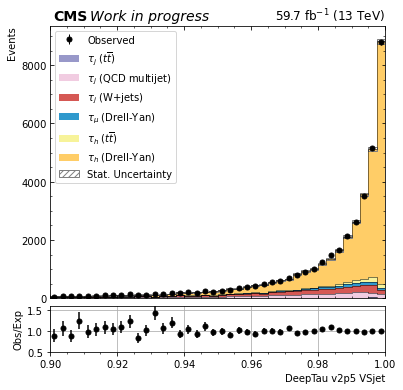

In [5]:
# Load model

mlpath="/home/russell/AdversarialTauML/TauMLTools/Training/python/2018v1/mlruns/12/"

expID = "e1f3ddb3c4c94128a34a7635c56322eb"

path_to_pred = mlpath + expID + "/artifacts/predictions/adversarial_predictions.csv"

df = pd.read_csv(path_to_pred)

# Split into different contributions
scores = {"data": df["Djet"].to_numpy()[i_data] }
weights = {"data": np.ones(len(i_data))}

mc_names = ["DYT", "TTT", "DYM", "TTJ", "WJ", "QCD"]
i_mc = ["i_"+ mc_name for mc_name in mc_names]
for n, i in zip(mc_names, i_mc):
    run_score = f"scores['{n}'] = df['Djet'].to_numpy()[{i}]"
    run_weights = f"weights['{n}'] = df['weights'].to_numpy()[{i}]"
    exec(run_score)
    exec(run_weights)
weights["MC_total"] = df["weights"].to_numpy()[i_MCtot]
scores["MC_total"] = df["Djet"].to_numpy()[i_MCtot]

r = plot(scores, weights, expID)

# DeepTau VSjet Distribution - Default Model


RATIOS:  [1.12590457 1.11420124 1.13740568 0.9375916  1.28417906 1.31049566
 1.21732485 1.08499974 1.10346638 1.23620844 1.06938146 1.03358838
 0.99832033 1.0165003  0.93199189 1.1300396  0.98328863 0.97757287
 1.12534557 1.00625496 0.9890226  1.00268287 1.01684885 1.05363554
 1.04969074 1.10990567 1.02626554 1.11675335 1.04879891 1.04267524
 1.01556639 1.03205209 1.05472214 1.03571363 1.07297151 0.96024028
 1.00552749 1.02884681 0.94486339 0.88348173]


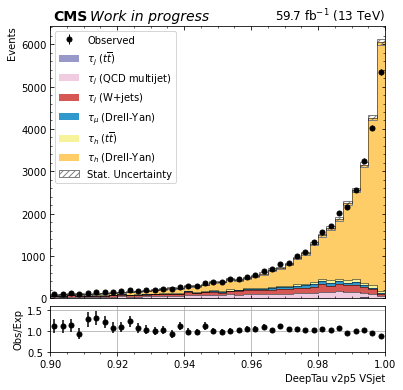

In [6]:
# Load model

mlpath="/home/russell/AdversarialTauML/TauMLTools/Training/python/2018v1/mlruns/12/"

def_expID = "5371f5d7080846c1a213f0e648471c11"

path_to_pred = mlpath + def_expID + "/artifacts/predictions/adversarial_predictions.csv"

default_df = pd.read_csv(path_to_pred)

# Split into different contributions
scores = {"data": default_df["Djet"].to_numpy()[i_data] }
weights = {"data": np.ones(len(i_data))}

mc_names = ["DYT", "TTT", "DYM", "TTJ", "WJ", "QCD"]
i_mc = ["i_"+ mc_name for mc_name in mc_names]
for n, i in zip(mc_names, i_mc):
    run_score = f"scores['{n}'] = default_df['Djet'].to_numpy()[{i}]"
    run_weights = f"weights['{n}'] = default_df['weights'].to_numpy()[{i}]"
    exec(run_score)
    exec(run_weights)
weights["MC_total"] = default_df["weights"].to_numpy()[i_MCtot]
scores["MC_total"] = default_df["Djet"].to_numpy()[i_MCtot]

r = plot(scores, weights, def_expID)

# y$_{adv}$ Distribution - Adversarial Models Only

In [7]:
bin_list = np.arange(0.4, 0.605, 0.005)
bins = bin_list[:-1] + np.diff(bin_list)/2
plot_width = bin_list[1]-bin_list[0]

      
def plot_datamc(y_data, y_mc, data_w, mc_w, runid):
    
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    
    ax.set_xlim(lower_lim,1)
    
    ax.errorbar(bins, y_mc, yerr = mc_w, xerr = plot_width/2, label=r"Monte Carlo ($\mu=0.4943$, $\sigma=0.014$)", linestyle="", color=blue)#, marker="o")
    ax.errorbar(bins, y_data, yerr = data_w, xerr = plot_width/2, label=r"Data ($\mu=0.4954$, $\sigma=0.013$)", linestyle="", color=red)#, marker="o")
    
    
    ax.tick_params(labelbottom=1,labelleft=True,labeltop=False,labelright=False,bottom=True,left=True,top=True,right=True, which='both', direction='in')
    ax.minorticks_on()
    ax.legend(loc= 'upper left')
    ax.set_ylabel("Events")
    header_y = 1.02
    ax.set_xlim(np.min(bin_list), np.max(bin_list))
    ax.set_xlabel(r"y$_{adv}$")
    ax.text(0.67, header_y, r"59.7 fb$^{-1}$ (13 TeV)", fontsize=12, transform=ax.transAxes)
    ax.text(0.01, header_y, 'CMS', fontsize=14, transform=ax.transAxes, fontweight='bold', fontfamily='sans-serif')
    ax.text(0.12, header_y, 'Work in progress', fontsize=14, transform=ax.transAxes, fontstyle='italic',fontfamily='sans-serif')
    
    ax.set_ylim(0,9000)
    
    plt.savefig(mlpath + expID + "/artifacts/plots/adversarial_yadv.pdf")
    
    plt.show()


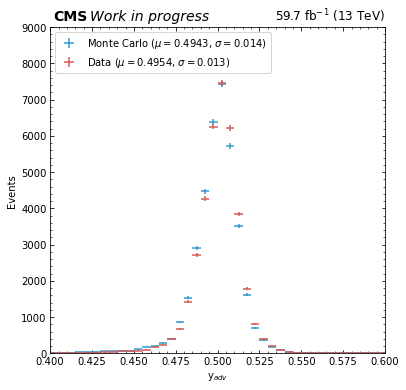

In [10]:
# Load pred
mlpath="/home/russell/AdversarialTauML/TauMLTools/Training/python/2018v1/mlruns/12/"

expID = "e1f3ddb3c4c94128a34a7635c56322eb"

path_to_pred = mlpath + expID + "/artifacts/predictions/adversarial_predictions.csv"

df = pd.read_csv(path_to_pred)

# Generate histograms of data/MC yadv distributions
data_y = df["y_pred_adv"].to_numpy()[np.where(df["y"].to_numpy()==1)]
mc_y = df["y_pred_adv"].to_numpy()[np.where(df["y"].to_numpy()==0)]
data_w = df["weights"].to_numpy()[np.where(df["y"].to_numpy()==1)]
mc_w = df["weights"].to_numpy()[np.where(df["y"].to_numpy()==0)]

data_counts = np.histogram(data_y, bin_list, weights=data_w)[0]
data_bin_w = np.sqrt(np.histogram(data_y, bin_list, weights=data_w**2)[0])
mc_counts = np.histogram(mc_y, bin_list, weights = mc_w)[0]
mc_bin_w = np.sqrt(np.histogram(mc_y, bin_list, weights = mc_w**2)[0])

plot_datamc(data_counts, mc_counts, data_bin_w, mc_bin_w, expID)

